## Formula Prior

### Binary Syntax Tree
The idea is to build a binary syntax tree for a formula, then randomly fill it with operations.
Then inside each node allow there to be a unary operation.
All operations are chosen randomly.

### Op Normalization
Before each op, we rescale the inputs by multiplying with a random number and then adding a random number.
After each op, we z-normalize the output.

Arg against this: this does not allow for abs, i.e. functions that strictly operate on positive numbers.

### Runtime Controls
Controls that are applied during the evaluation of the formula, as opposed to posthoc controls which are applied after evaluation.

- op percentages, or at first just whether an op is included
- chance of adding unary ops
- factor and bias distribution
- internal randomness
- final randomness
- likelihood internal randomness
- tree size distribution
- constant share distribution
- sparsity in the used variables

### Posthoc controls
- outlier percentage
- monotonicity in a dim (for this to work, we'd need to drag that property through the tree, there might be other properties like this, though)
- rough max position (as an alternative to monotonicity, one could allow providing this in a sparse format)
- rough max value
- rough number of local optima

### Posthoc filtering
- constant datasets
- nan datasets

### What properties does this prior have?
- forward formulation
- simple formulaic representation (esp. without noise)
- simplicity bias, with the right dist over number of input nodes
- high stability (to be evaluated on large sample)
- multimodal dists, thanks to noises and gates
- hard borders thanks to gates


### Look out for the following
- likelihood of features not being used
- there is a (relatively small) upper limit on the complexity of the function, that is about #features binary ops and #features unary ops. This should be rather low.
    - simple lifts: allow input node repetition, allow multiple unary ops per binary op
    - more thorough lift: allow dags

In [2]:
import numpy as np
import torch

# all ops are implemented in torch mapping vectors of length n to vectors of length n
### binary operations

def add(x, y):
    return (x + y)

def mul(x, y):
    return x * y

def gate(x, y):
    return (x > 0) * y

def power(x, y):
    return x.abs() ** y

def rr_ad_gate(x, y):
    bound_index = torch.randint(len(x), (1,)).squeeze()
    return (x > x[bound_index]) * y

binary_ops = {
    'add': add,
    'mul': mul,
    'gate': gate,
    'power': power,
    'rr_ad_gate': rr_ad_gate
}

### unary operations

def ident(x):
    return x

def absolute(x):
    return x.abs()

def inv(x):
    return 1 / x

def sin(x):
    return torch.sin(x)

def exp(x):
    return torch.exp(x)

def log(x):
    return torch.log(x.abs())

def sqrt(x):
    return torch.sqrt(x.abs())

def square(x):
    return x ** 2

def sigmoid(x):
    return torch.sigmoid(x)

def cubic(x):
    return x ** 3

def relative_noise__random(x):
    return x * torch.randn_like(x)

unary_ops = {
    'ident': ident,
    'abs': absolute,
    'inv': inv,
    'sin': sin,
    'exp': exp,
    'log': log,
    'sqrt': sqrt,
    'square': square,
    'sigmoid': sigmoid,
    'cubic': cubic,
    'rr_rel_noise': relative_noise__random,
}

[autoreload of pfns.priors.prior failed: Traceback (most recent call last):
  File "/Users/samuelmueller/Documents/PFNs/.conda/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 273, in check
    superreload(m, reload, self.old_objects)
  File "/Users/samuelmueller/Documents/PFNs/.conda/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 471, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "/Users/samuelmueller/Documents/PFNs/.conda/lib/python3.11/importlib/__init__.py", line 159, in reload
    raise ImportError(msg.format(parent_name),
ImportError: parent 'pfns.priors' not in sys.modules
]


In [3]:
from typing import Callable, Tuple, List
import torch
import random
import numpy as np
import numpy.typing as npt

node_dtype = np.dtype([
    ('type', 'U6'),  # The type of the node can be 'binary', 'unary', or 'leaf'
    ('op_or_input', 'U12'),  # The operation (e.g. 'add') or input index, if it is a leaf.
    ('left', 'i4'),  # The index of the left child in the tree, -1 if no left child.
    ('right', 'i4'),  # The index of the right child in the tree, -1 if no right child.
    ('print', 'U3'),  # Whether to print ('yes') the node during evaluation, empty ('') otherwise. This flag is there to be used rather freely.
    ('factor_left', 'f4'),  # The factor applied to the left child before applying the operation.
    ('factor_right', 'f4'),  # The factor applied to the right child before applying the operation.
    ('bias_left', 'f4'),  # The bias applied to the left child before applying the operation.
    ('bias_right', 'f4')  # The bias applied to the right child before applying the operation.
])


def sample_tree(num_leaves: int, binary_op_sampler: Callable[[], str], unary_op_sampler: Callable[[], str | None] = None, 
                          factor_bias_sampler: Callable[[str, int], Tuple[List[float], List[float]]] | None = None) -> Tuple[np.ndarray, List[int]]:  # the array is a list of type node_dtype
    """
    Samples a binary operation tree using NumPy structured array representation.

    Starts with a single leaf node and iteratively replaces random leaf nodes with
    binary operations (which create two new leaf nodes) until the target number of
    leaves is reached. Each binary operation node has two children, and each leaf
    represents an input variable.

    Each node (binary and leaf) is (potentially) wrapped with a unary operation, the
    unary operation is chosen randomly by the unary_op_sampler.

    Args:
        num_leaves: The desired number of leaves in the final tree.
        binary_op_sampler: A function that returns a binary operation name (str) and does not take any arguments.
        unary_op_sampler: A function that returns a unary operation name (str) or None, if it returns None, no unary operations will be added.
                         
        factor_bias_sampler: A function that takes (op, num_inputs) and returns 
                             a tuple of lists (factors, biases), where each list
                             has length num_inputs. These factors and biases
                             are applied to the inputs of the operation.
                             The outputs of each operation are z-normalized.

    Returns:
        A tuple of a NumPy structured array representing the tree using `node_dtype`
        and a list of indices of the leaf nodes.
        The root of the tree is at index 0.
    """
    if num_leaves < 1:
        raise ValueError("Target leaves must be at least 1.")

    # Assume binary_ops and unary_ops dictionaries are defined in the global scope
    # Assume node_dtype is defined in the global scope
    
    # Default factor_bias_sampler returns 1.0 for factors and 0.0 for biases
    if factor_bias_sampler is None:
        factor_bias_sampler = lambda op, num_inputs: (
            [1.0] * num_inputs,  # factors
            [0.0] * num_inputs   # biases
        )

    # Handle base case: single leaf
    if num_leaves == 1:
        # For simplicity, don't add unary op to the single leaf case,
        # although it could be implemented.
        return np.array([('leaf', '0', -1, -1, '', 1.0, 1.0, 0.0, 0.0)], dtype=node_dtype)

    tree_nodes = [] # List to store node tuples before converting to NumPy array
    leaf_indices = [] # Stores indices of *actual leaf nodes* in tree_nodes
    next_input_idx = 0

    # Helper function to add a node to the list and return its index
    def add_node(node_data):
        idx = len(tree_nodes)
        # Ensure node_data matches node_dtype structure
        tree_nodes.append(node_data)
        return idx

    # Helper function to potentially wrap a node with a unary operation
    def maybe_wrap_with_unary(node_idx_to_wrap):
        # This function assumes unary_op_sampler and add_node are available in its scope
        if unary_op_sampler is None:
            return node_idx_to_wrap
        unary_op = unary_op_sampler()
        if unary_op is None:
            return node_idx_to_wrap

        # Get factors and biases for the unary operation
        factors, biases = factor_bias_sampler(unary_op, 1)
        
        # Insert the unary node pointing to the original node
        unary_node_idx = add_node(('unary', unary_op, node_idx_to_wrap, -1, '', 
                                  factors[0], 1.0, biases[0], 0.0))
        return unary_node_idx

    # Initialize the tree with the first leaf node
    root_leaf_idx = add_node(('leaf', str(next_input_idx), -1, -1, '', 1.0, 1.0, 0.0, 0.0))
    leaf_indices.append(root_leaf_idx)
    next_input_idx += 1

    # Iteratively expand leaves until the target number is reached
    while len(leaf_indices) < num_leaves:
        # Choose a random leaf index from the list of current leaf indices
        idx_in_leaves_list = random.randrange(len(leaf_indices))
        # Get the actual index of the node in the tree_nodes list
        node_to_expand_idx = leaf_indices[idx_in_leaves_list]

        # Retrieve the input variable name of the leaf being expanded
        # Important: Access tree_nodes *before* potentially overwriting the node
        current_input_var = tree_nodes[node_to_expand_idx][1]

        # Sample a binary operation
        binary_op = binary_op_sampler()

        # Get factors and biases for the binary operation
        factors, biases = factor_bias_sampler(binary_op, 2)

        # Create the new left leaf node (reusing the current input variable)
        left_leaf_idx = add_node(('leaf', current_input_var, -1, -1, '', 1.0, 1.0, 0.0, 0.0))
        # Optionally wrap the new left leaf node with unary op(s)
        # The maybe_wrap function returns the index of the node that should be the child (either the leaf or the unary op)
        left_child_node_idx = maybe_wrap_with_unary(left_leaf_idx)

        # Create the new right leaf node (using the next available input variable)
        right_leaf_idx = add_node(('leaf', str(next_input_idx), -1, -1, '', 1.0, 1.0, 0.0, 0.0))
        next_input_idx += 1
        # Optionally wrap the new right leaf node with unary op(s)
        right_child_node_idx = maybe_wrap_with_unary(right_leaf_idx)

        # Update the node that was expanded: change it from a leaf to a binary node
        # Its children are the (potentially wrapped) new leaf nodes
        tree_nodes[node_to_expand_idx] = ('binary', binary_op, left_child_node_idx, right_child_node_idx, '', 
                                         factors[0], factors[1], biases[0], biases[1])

        # Update the list of leaf indices:
        # Replace the index of the expanded leaf with the index of the new left leaf
        leaf_indices[idx_in_leaves_list] = left_leaf_idx
        # Add the index of the new right leaf to the list
        leaf_indices.append(right_leaf_idx)

    # Convert the list of node tuples to a NumPy structured array
    return np.array(tree_nodes, dtype=node_dtype), leaf_indices

def evaluate_tree(tree: np.ndarray, inputs: torch.Tensor, node_idx: int = 0) -> torch.Tensor:
    """
    Evaluates a binary syntax tree on the given inputs.
    This function recursively calls itself to evaluate.
    This might be a bit slow, but at least it is batched
    
    Args:
        tree: NumPy structured array representing the tree (from sample_tree)
        inputs: Tensor of shape [batch_size, num_inputs] containing input values
        node_idx: Index of the node to evaluate (default: 0 for root)
        
    Returns:
        Tensor of shape [batch_size] with the result of evaluating the tree
    """
    node = tree[node_idx]
    node_type = node['type']
    
    if node_type == 'leaf':
        # Leaf node: return the corresponding input
        input_idx: int = int(node['op_or_input'])
        result = inputs[:, input_idx]
        if node['print'] == 'yes':
            print(f"Leaf node {node_idx} (input {input_idx}) unnormalized: {result}")
    
    elif node_type == 'unary':
        # Unary node: apply unary operation to child
        op_name: str = node['op_or_input']
        child_idx = node['left']  # Unary nodes only have left child
        
        if op_name not in unary_ops:
            raise ValueError(f"Unknown unary operation: {op_name}")
        
        # Apply factor and bias to the child value
        child_value = evaluate_tree(tree, inputs, child_idx)
        transformed_value = node['factor_left'] * child_value + node['bias_left']
        
        # Apply the unary operation
        result = unary_ops[op_name](transformed_value)
        
        if node['print'] == 'yes':
            print(f"Unary node {node_idx} (op {op_name}) unnormalized: {result}")
    
    elif node_type == 'binary':
        # Binary node: apply binary operation to children
        op_name = node['op_or_input']
        left_idx = node['left']
        right_idx = node['right']
        
        if op_name not in binary_ops:
            raise ValueError(f"Unknown binary operation: {op_name}")
        
        # Get child values
        left_value = evaluate_tree(tree, inputs, left_idx)
        right_value = evaluate_tree(tree, inputs, right_idx)
        
        # Apply factors and biases
        transformed_left = node['factor_left'] * left_value + node['bias_left']
        transformed_right = node['factor_right'] * right_value + node['bias_right']
        
        # Apply the binary operation
        result = binary_ops[op_name](transformed_left, transformed_right)
        
        if node['print'] == 'yes':
            print(f"Binary node {node_idx} (op {op_name}) unnormalized: {result}")
            print(f"left: {transformed_left}, right: {transformed_right}")
    else:
        raise ValueError(f"Unknown node type: {node_type}")
        
    # Apply z-normalization across the batch
    result = (result - result.mean()) / (result.std() + 1e-8)
    return result
    



In [4]:
def bias_str(bias):
    bias_sign = "+" if bias >= 0 else "-"
    return f'{bias_sign}{abs(bias):.2f}'

def print_tree(tree, node_idx=0, indent=0, prefix=""):
    """
    Print a tree in a human-readable format with indentation to show hierarchy.
    
    Args:
        tree: The tree structure (list of nodes)
        node_idx: Current node index to print
        indent: Current indentation level
        edge_label: Label for the edge leading to this node
    """
    node = tree[node_idx]
    node_type = node['type']
    
    # Print the current node with indentation
    indent_str = "  " * indent
    prefix = f"{indent_str}{prefix}"
    
    if node_type == 'input' or node_type == 'leaf':
        print(f"{prefix}{node_type.upper()} {node['op_or_input']}")
    elif node_type == 'unary':
        op_name = node['op_or_input']
        
        # Print child with increased indentation
        print(f"{prefix}{op_name}")
        factor = node['factor_left']
        bias = node['bias_left']
        print_tree(tree, node['left'], indent + 1, prefix=f'(x{factor:.2f}){bias_str(bias)} ')
    elif node_type == 'binary':
        op_name = node['op_or_input']
        print(f"{prefix}{op_name}")
        
        # Print left child with increased indentation
        factor = node['factor_left']
        bias = node['bias_left']
        print_tree(tree, node['left'], indent + 1, prefix=f'(x{factor:.2f}){bias_str(bias)} ')
        
        # Print right child with increased indentation
        factor = node['factor_right']
        bias = node['bias_right']
        print_tree(tree, node['right'], indent + 1, prefix=f'(x{factor:.2f}){bias_str(bias)} ')

In [5]:
def sample_x(num_samples, num_features, num_tree_inputs, num_constants):
    """
    Sample input data for tree evaluation.
    Only part of the input of the tree is used.
    
    Args:
        num_samples: Number of data points to generate
        num_features: Total number of dimensions in the input space
        num_tree_inputs: Number of inputs the tree expects
        num_constants: Number of constant inputs to use. The remaining (num_tree_inputs - num_constants) will be random dimensions.
        
    Returns:
        x: Actual input data of shape [num_samples, num_features]
        tree_inputs: Inputs for the tree of shape [num_samples, num_tree_inputs]
    """
    assert num_tree_inputs >= num_constants

    # Generate random input data
    x = torch.randn(num_samples, num_features)
    
    # Initialize tree inputs, the first num_constants are constant inputs and thus left 0.
    tree_inputs = torch.zeros(num_samples, num_tree_inputs)

    # Fill remaining inputs with random dimensions from x
    if num_tree_inputs > num_constants:
        num_dims_left_to_fill = num_tree_inputs - num_constants
        if num_features >= num_dims_left_to_fill:
            # Select random dimensions from input space
            selected_dims = random.sample(range(num_features), num_dims_left_to_fill)
        else:
            # Sample with replacement to allow redraws
            selected_dims = random.choices(range(num_features), k=num_dims_left_to_fill)
        
        # Map selected dimensions to remaining tree inputs
        if selected_dims: # Ensure selected_dims is not empty to prevent errors with slicing
            tree_inputs[:, num_constants : num_constants + len(selected_dims)] = x[:, selected_dims]
    
    return x, tree_inputs


def sample_dataset(num_samples, num_features, num_tree_leaves=2, num_constants=0):

    sampled_tree_np, leaf_indices = sample_tree(
        num_leaves=num_tree_leaves, binary_op_sampler=lambda: random.choice(list(set(binary_ops.keys()))),# - {'gate', 'power'})), 
        unary_op_sampler=lambda: random.choice([None] + list(unary_ops.keys())),
        factor_bias_sampler=lambda op, num_inputs: (
            torch.rand(num_inputs)*2.-1.,  # factors
            torch.rand(num_inputs)*2.-1.   # biases
        ))

    print("Sampled Tree (NumPy Array):")
    print(list(enumerate(sampled_tree_np)))
    print("Leaf Indices:")
    print(leaf_indices)
    print("Has sin:", 'sin' in sampled_tree_np['op_or_input'])

    x, tree_inputs = sample_x(num_samples, num_features, num_tree_leaves, num_constants)
    y = evaluate_tree(sampled_tree_np, tree_inputs)
    return x, y, sampled_tree_np

Sampled Tree (NumPy Array):
[(0, ('binary', 'mul', 2, 4, '', -0.32515812, -0.8765712, -0.829877, 0.40079272)), (1, ('leaf', '0', -1, -1, '', 1., 1., 0., 0.)), (2, ('unary', 'cubic', 1, -1, '', -0.01001596, 1., 0.9302839, 0.)), (3, ('leaf', '1', -1, -1, '', 1., 1., 0., 0.)), (4, ('unary', 'abs', 3, -1, '', 0.9604434, 1., -0.85237706, 0.))]
Leaf Indices:
[1, 3]
Has sin: False
Sampled Tree (NumPy Array):
[(0, ('binary', 'power', 2, 4, '', -0.7737756, 0.25508273, 0.97543156, 0.3297373)), (1, ('leaf', '0', -1, -1, '', 1., 1., 0., 0.)), (2, ('unary', 'sqrt', 1, -1, '', 0.71254945, 1., -0.57793057, 0.)), (3, ('leaf', '1', -1, -1, '', 1., 1., 0., 0.)), (4, ('unary', 'cubic', 3, -1, '', 0.40688598, 1., 0.05256236, 0.))]
Leaf Indices:
[1, 3]
Has sin: False
Sampled Tree (NumPy Array):
[(0, ('binary', 'gate', 2, 4, '', 0.32331133, -0.4795649, 0.32671058, -0.25729978)), (1, ('leaf', '0', -1, -1, '', 1., 1., 0., 0.)), (2, ('unary', 'exp', 1, -1, '', 0.42352736, 1., -0.44426548, 0.)), (3, ('leaf', '1

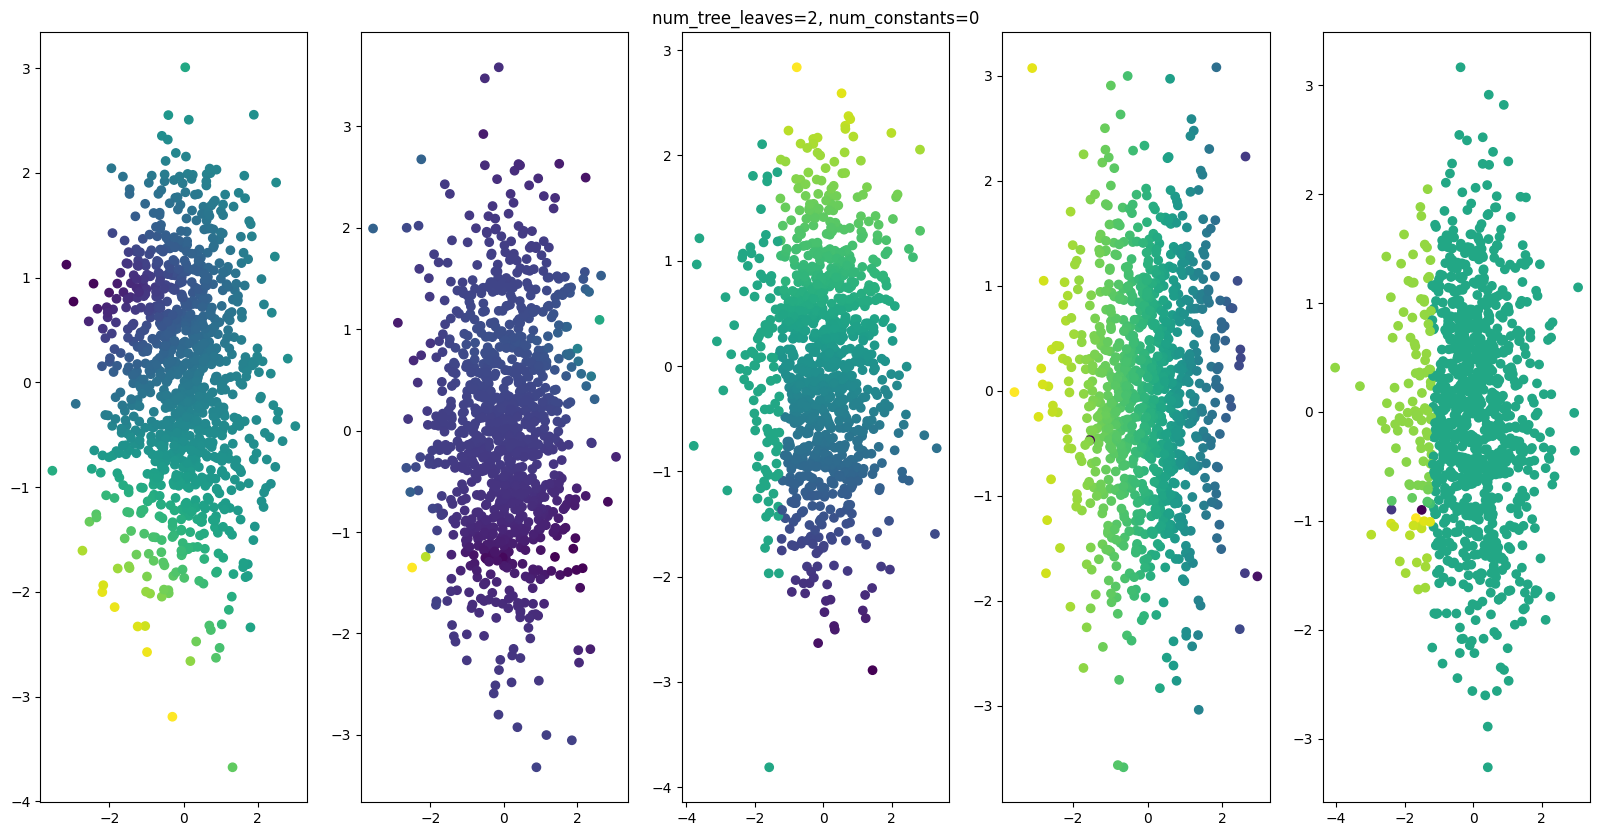

Sampled Tree (NumPy Array):
[(0, ('binary', 'gate', 2, 4, '', 0.80405474, 0.9263394, -0.55239797, 0.1395843)), (1, ('leaf', '0', -1, -1, '', 1., 1., 0., 0.)), (2, ('unary', 'sqrt', 1, -1, '', 0.18478811, 1., -0.5210831, 0.)), (3, ('binary', 'power', 6, 8, '', -0.13392985, 0.58175266, -0.60626316, -0.36251152)), (4, ('unary', 'sqrt', 3, -1, '', 0.3571366, 1., -0.46095085, 0.)), (5, ('leaf', '1', -1, -1, '', 1., 1., 0., 0.)), (6, ('unary', 'inv', 5, -1, '', 0.59421766, 1., 0.3929733, 0.)), (7, ('leaf', '2', -1, -1, '', 1., 1., 0., 0.)), (8, ('unary', 'ident', 7, -1, '', -0.43150878, 1., 0.62276745, 0.))]
Leaf Indices:
[1, 5, 7]
Has sin: False
Sampled Tree (NumPy Array):
[(0, ('binary', 'add', 1, 2, '', -0.132985, -0.22079813, -0.00988328, 0.9515108)), (1, ('leaf', '0', -1, -1, '', 1., 1., 0., 0.)), (2, ('binary', 'power', 4, 6, '', -0.74885225, -0.97357464, 0.67597246, 0.31940305)), (3, ('leaf', '1', -1, -1, '', 1., 1., 0., 0.)), (4, ('unary', 'rr_rel_noise', 3, -1, '', 0.10944486, 1., -

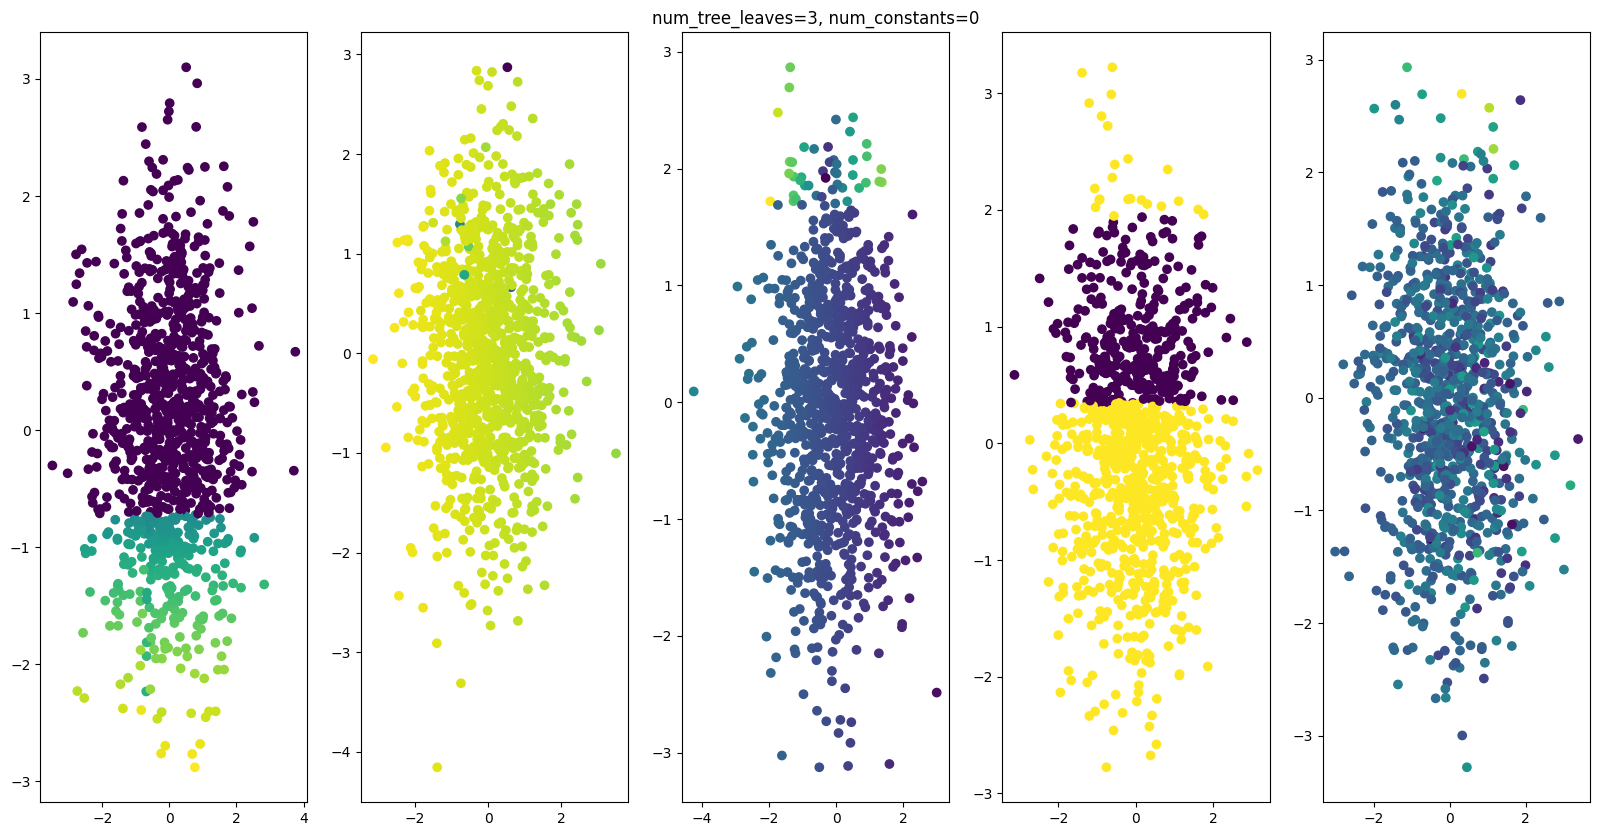

In [6]:
import matplotlib.pyplot as plt

num_seeds = 5

for num_tree_leaves in range(2,4):
    for num_constants in [0]:
        fig, ax = plt.subplots(1, num_seeds, figsize=(20,10))
        
        for seed_i in range(num_seeds):
            x, y, tree = sample_dataset(1000, 2, num_tree_leaves, num_constants)
            ax[seed_i].scatter(x[:,0],x[:,1],c=y)
        ax[len(ax)//2].set_title(f"{num_tree_leaves=}, {num_constants=}")
        plt.show()

Sampled Tree (NumPy Array):
[(0, ('binary', 'gate', 2, 4, '', -0.6487051, -0.9403758, -0.15148723, 0.8230479)), (1, ('leaf', '0', -1, -1, '', 1., 1., 0., 0.)), (2, ('unary', 'sqrt', 1, -1, '', 0.13430965, 1., 0.21405518, 0.)), (3, ('leaf', '1', -1, -1, '', 1., 1., 0., 0.)), (4, ('unary', 'sqrt', 3, -1, '', -0.17415643, 1., 0.05707812, 0.))]
Leaf Indices:
[1, 3]
Has sin: False
Sampled Tree (NumPy Array):
[(0, ('binary', 'power', 2, 4, '', 0.79065084, -0.8739735, 0.7115077, -0.6519356)), (1, ('leaf', '0', -1, -1, '', 1., 1., 0., 0.)), (2, ('unary', 'ident', 1, -1, '', 0.18392813, 1., -0.75885725, 0.)), (3, ('leaf', '1', -1, -1, '', 1., 1., 0., 0.)), (4, ('unary', 'sigmoid', 3, -1, '', 0.05639076, 1., 0.6882887, 0.))]
Leaf Indices:
[1, 3]
Has sin: False
Sampled Tree (NumPy Array):
[(0, ('binary', 'gate', 2, 4, '', 0.02546287, -0.9553424, -0.9955826, 0.00791502)), (1, ('leaf', '0', -1, -1, '', 1., 1., 0., 0.)), (2, ('unary', 'sqrt', 1, -1, '', -0.28602588, 1., -0.01877856, 0.)), (3, ('leaf

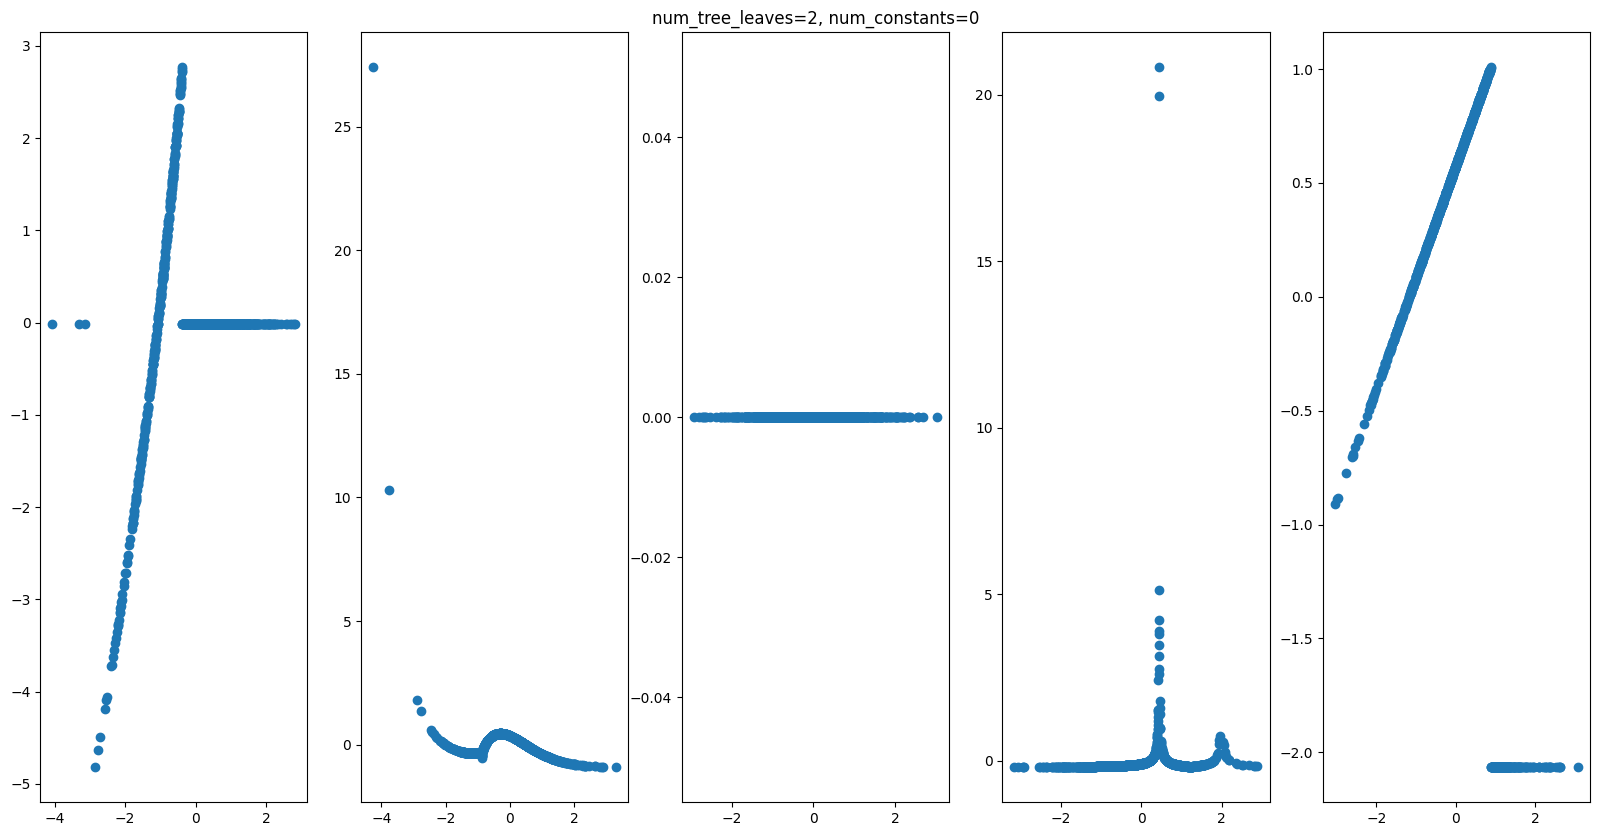

Sampled Tree (NumPy Array):
[(0, ('binary', 'rr_ad_gate', 2, 4, '', 0.6461309, 0.9251354, -0.36897874, -0.5556636)), (1, ('leaf', '0', -1, -1, '', 1., 1., 0., 0.)), (2, ('unary', 'sin', 1, -1, '', -0.74349153, 1., -0.4123175, 0.)), (3, ('leaf', '1', -1, -1, '', 1., 1., 0., 0.)), (4, ('unary', 'ident', 3, -1, '', 0.68848765, 1., -0.8207283, 0.))]
Leaf Indices:
[1, 3]
Has sin: True
Sampled Tree (NumPy Array):
[(0, ('binary', 'gate', 2, 4, '', 0.45674777, -0.76193225, 0.47892404, -0.28654504)), (1, ('leaf', '0', -1, -1, '', 1., 1., 0., 0.)), (2, ('unary', 'sin', 1, -1, '', 0.27245283, 1., 0.20575058, 0.)), (3, ('leaf', '1', -1, -1, '', 1., 1., 0., 0.)), (4, ('unary', 'rr_rel_noise', 3, -1, '', -0.23520386, 1., -0.72440565, 0.))]
Leaf Indices:
[1, 3]
Has sin: True
Sampled Tree (NumPy Array):
[(0, ('binary', 'rr_ad_gate', 2, 4, '', -0.92417693, -0.62233424, -0.9822867, 0.37024486)), (1, ('leaf', '0', -1, -1, '', 1., 1., 0., 0.)), (2, ('unary', 'sqrt', 1, -1, '', 0.38454843, 1., -0.47278774,

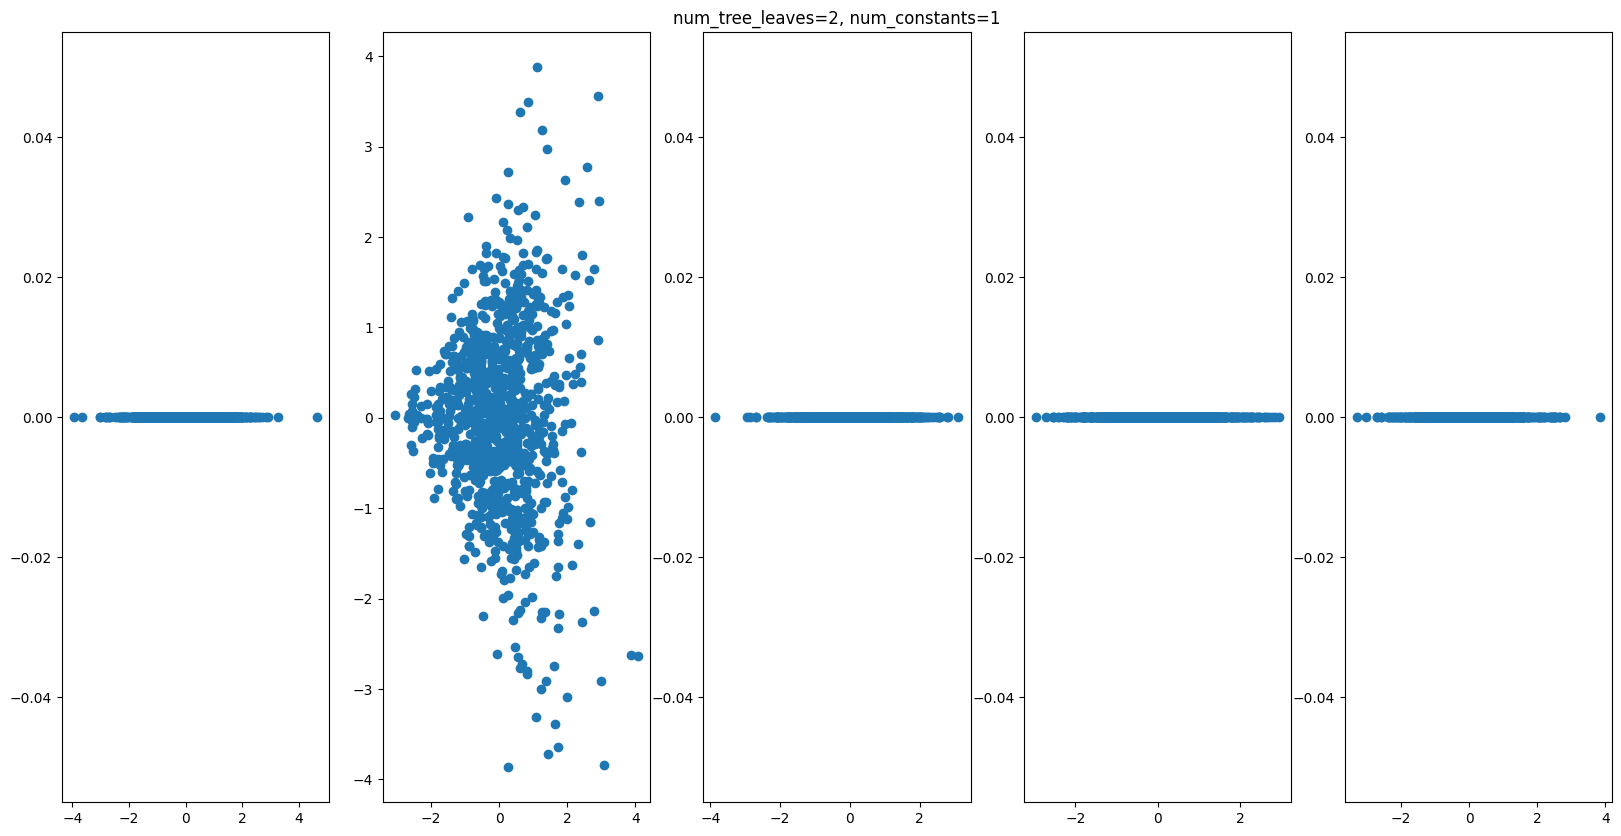

Sampled Tree (NumPy Array):
[(0, ('binary', 'rr_ad_gate', 2, 4, '', 0.5467597, 0.2772324, 0.48563766, -0.12116134)), (1, ('binary', 'add', 6, 8, '', -0.3103509, -0.32832158, -0.08034527, -0.4277736)), (2, ('unary', 'sin', 1, -1, '', 0.57942116, 1., 0.5784129, 0.)), (3, ('leaf', '1', -1, -1, '', 1., 1., 0., 0.)), (4, ('unary', 'square', 3, -1, '', -0.37218118, 1., 0.4000337, 0.)), (5, ('leaf', '0', -1, -1, '', 1., 1., 0., 0.)), (6, ('unary', 'sqrt', 5, -1, '', -0.99884725, 1., 0.4178028, 0.)), (7, ('leaf', '2', -1, -1, '', 1., 1., 0., 0.)), (8, ('unary', 'square', 7, -1, '', -0.13043284, 1., -0.34219348, 0.))]
Leaf Indices:
[5, 3, 7]
Has sin: True
Sampled Tree (NumPy Array):
[(0, ('binary', 'add', 2, 4, '', 0.50045645, 0.29299545, 0.47086108, 0.25956213)), (1, ('binary', 'power', 6, 8, '', -0.71882606, 0.7349032, -0.55013525, 0.22365081)), (2, ('unary', 'sigmoid', 1, -1, '', 0.59520376, 1., -0.70292807, 0.)), (3, ('leaf', '1', -1, -1, '', 1., 1., 0., 0.)), (4, ('unary', 'abs', 3, -1, ''

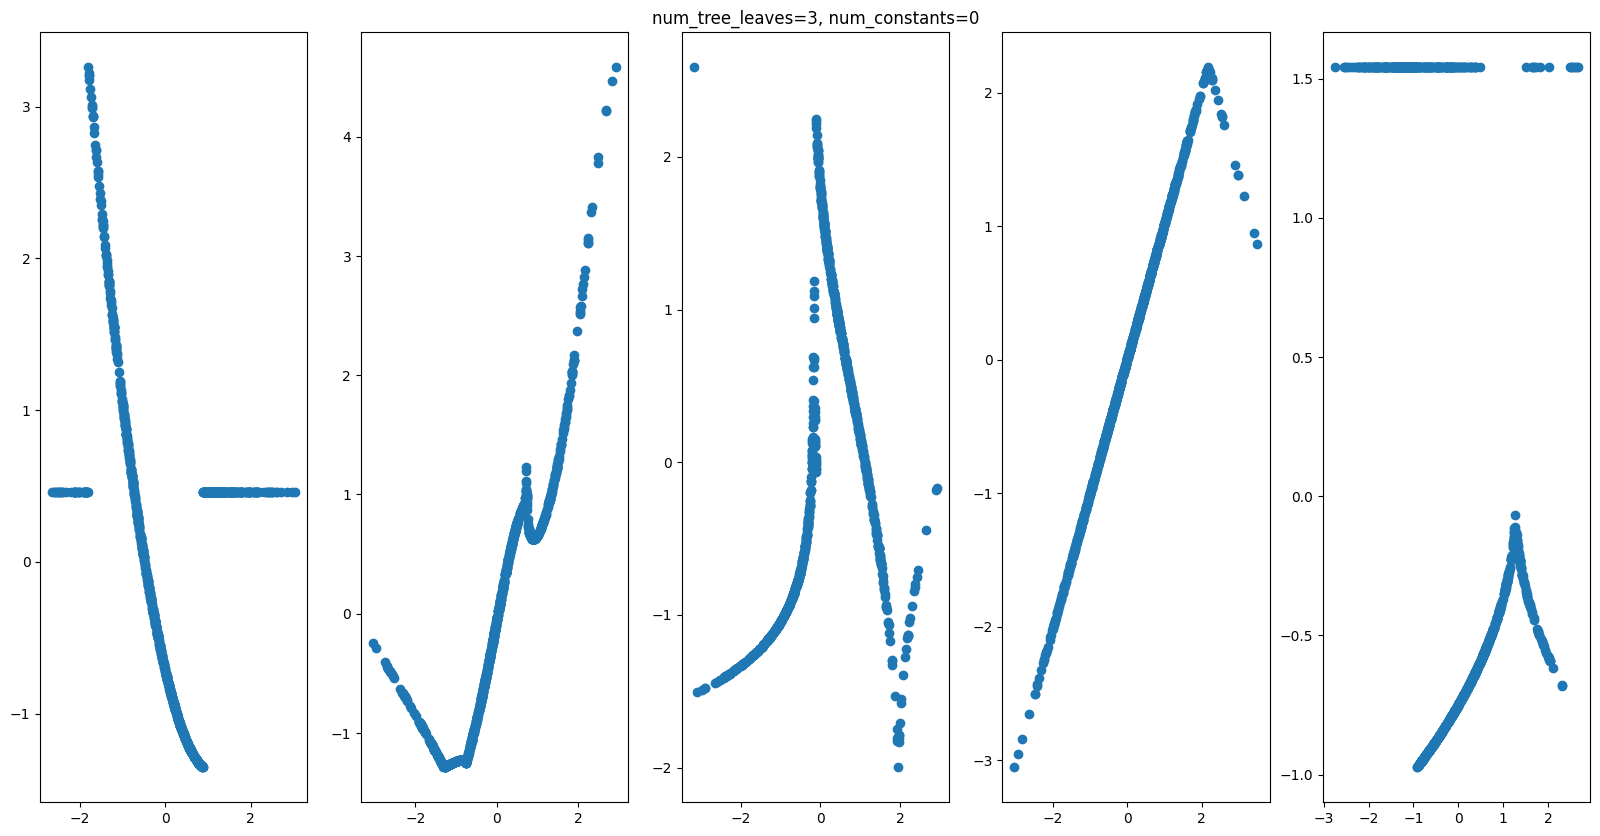

Sampled Tree (NumPy Array):
[(0, ('binary', 'gate', 2, 4, '', -0.09126341, -0.5355052, -0.05804956, -0.35827518)), (1, ('binary', 'rr_ad_gate', 6, 8, '', 0.6629735, 0.5759584, -0.40841925, -0.1989665)), (2, ('unary', 'sqrt', 1, -1, '', 0.5996423, 1., 0.42651355, 0.)), (3, ('leaf', '1', -1, -1, '', 1., 1., 0., 0.)), (4, ('unary', 'sin', 3, -1, '', -0.4403143, 1., 0.53879416, 0.)), (5, ('leaf', '0', -1, -1, '', 1., 1., 0., 0.)), (6, ('unary', 'cubic', 5, -1, '', 0.05201876, 1., -0.5495002, 0.)), (7, ('leaf', '2', -1, -1, '', 1., 1., 0., 0.)), (8, ('unary', 'ident', 7, -1, '', -0.14392579, 1., 0.33543944, 0.))]
Leaf Indices:
[5, 3, 7]
Has sin: True
Sampled Tree (NumPy Array):
[(0, ('binary', 'mul', 2, 4, '', 0.80594885, -0.43688953, -0.98416626, 0.44373262)), (1, ('leaf', '0', -1, -1, '', 1., 1., 0., 0.)), (2, ('unary', 'sin', 1, -1, '', 0.8609781, 1., -0.19753742, 0.)), (3, ('binary', 'rr_ad_gate', 6, 8, '', -0.6052809, 0.65652776, 0.5785979, 0.18266976)), (4, ('unary', 'square', 3, -1, 

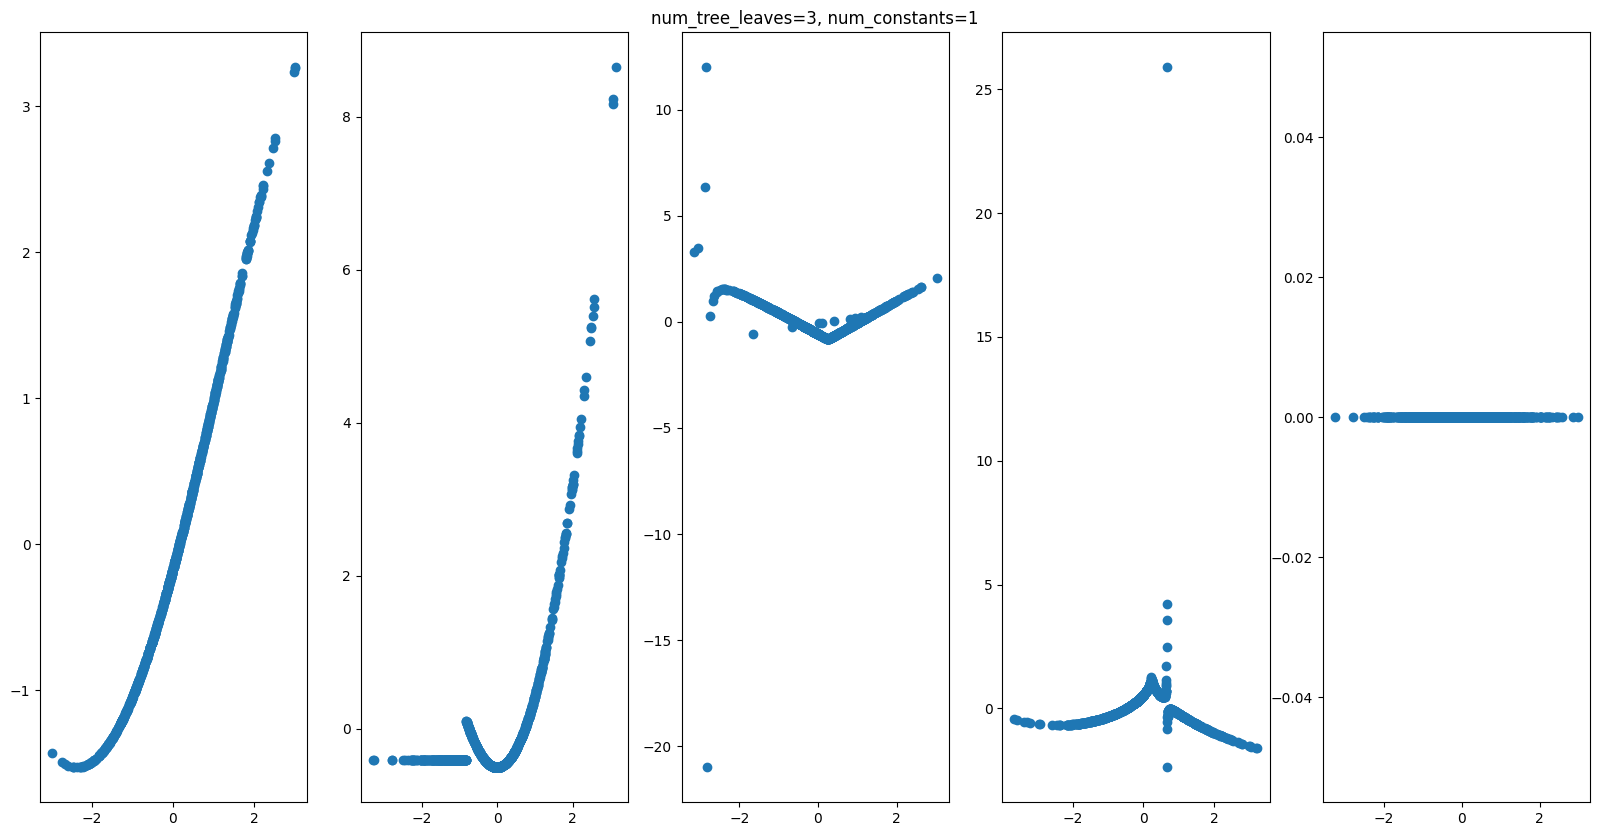

Sampled Tree (NumPy Array):
[(0, ('binary', 'mul', 2, 4, '', 0.10452521, 0.23371136, -0.35545874, 0.33277643)), (1, ('binary', 'power', 6, 7, '', 0.64105654, -0.38898838, 0.42084408, 0.33091724)), (2, ('unary', 'inv', 1, -1, '', 0.04674506, 1., -0.49155962, 0.)), (3, ('leaf', '1', -1, -1, '', 1., 1., 0., 0.)), (4, ('unary', 'sin', 3, -1, '', -0.44194925, 1., -0.20717037, 0.)), (5, ('leaf', '0', -1, -1, '', 1., 1., 0., 0.)), (6, ('unary', 'rr_rel_noise', 5, -1, '', -0.40818143, 1., -0.8731686, 0.)), (7, ('leaf', '2', -1, -1, '', 1., 1., 0., 0.))]
Leaf Indices:
[5, 3, 7]
Has sin: True
Sampled Tree (NumPy Array):
[(0, ('binary', 'mul', 2, 4, '', -0.5030807, 0.3330084, -0.03621709, -0.75842786)), (1, ('binary', 'rr_ad_gate', 6, 8, '', -0.703429, -0.46987367, -0.9492105, -0.55949056)), (2, ('unary', 'sin', 1, -1, '', 0.61950433, 1., -0.23361862, 0.)), (3, ('leaf', '1', -1, -1, '', 1., 1., 0., 0.)), (4, ('unary', 'sqrt', 3, -1, '', 0.47511244, 1., 0.11887956, 0.)), (5, ('leaf', '0', -1, -1, 

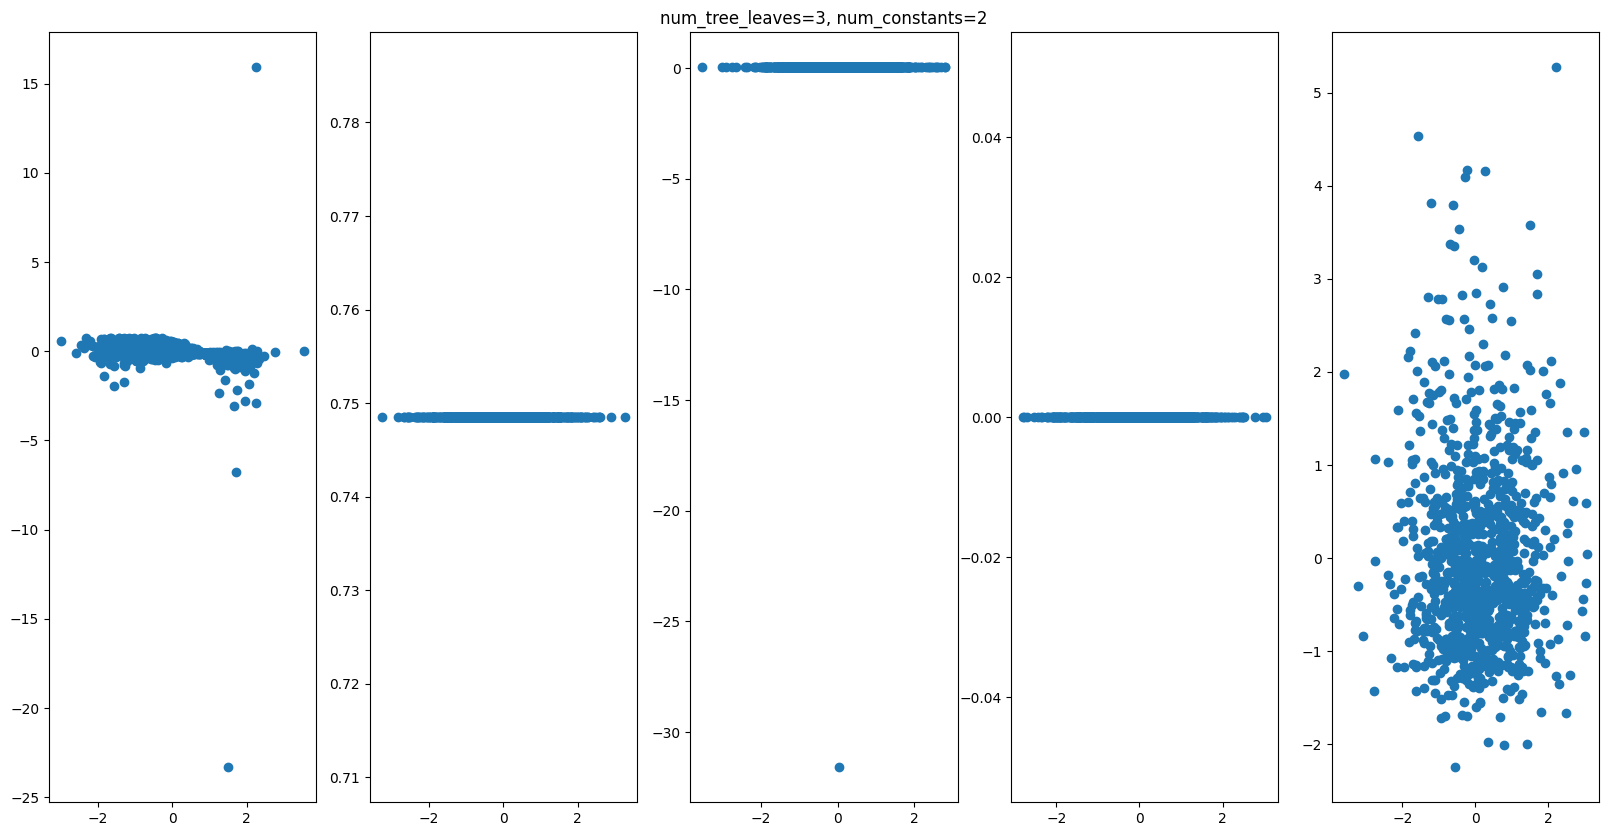

In [42]:
import matplotlib.pyplot as plt

num_seeds = 5

for num_tree_leaves in range(2,4):
    for num_constants in range(num_tree_leaves):
        fig, ax = plt.subplots(1, num_seeds, figsize=(20,10))
        for seed_i in range(num_seeds):
            x, y, tree = sample_dataset(1000, 1, num_tree_leaves, num_constants)
            ax[seed_i].scatter(x[:, 0], y)
        ax[len(ax)//2].set_title(f"{num_tree_leaves=}, {num_constants=}")
        plt.show()

In [465]:
debug_np_tree = sampled_tree_np.copy()
for node in debug_np_tree:
    node['print'] = 'yes'

y = evaluate_tree_np(debug_np_tree, tree_inputs)

Leaf node 1 (input 0) unnormalized: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 

In [46]:
import torch
import random
import numpy as np

# Define the structured data type for tree nodes in NumPy
# 'U6' for type string ('binary', 'leaf')
# 'U3' for operation ('add', 'sub', 'mul') or input index ('0', '1', ...)
# 'U3' for unary operation ('neg', 'inv', '') or empty string if none
# 'i4' for 32-bit integer indices of children (-1 indicates no child)
node_dtype = np.dtype([
    ('type', 'U6'),
    ('op_or_input', 'U3'),
    ('unary_op', 'U7'),
    ('left', 'i4'),
    ('right', 'i4')
])

def sample_binary_tree_np(target_leaves, binary_op_sampler=None, unary_op_sampler=None):
    """
    Samples a binary operation tree using NumPy structured array representation.

    Starts with one leaf and iteratively extends a random leaf with a binary
    operation until the target number of leaves is reached.

    Args:
        target_leaves: The desired number of leaf nodes in the final tree.
        binary_op_sampler: A function that returns a binary operation name or None.
                          If None, defaults to randomly selecting from binary_ops.
        unary_op_sampler: A function that returns a unary operation name or None.
                         If None, no unary operations will be used.

    Returns:
        A NumPy structured array representing the tree.
        The array might be larger than necessary, containing unused slots if
        pre-allocated. The actual tree structure is defined by the indices starting from 0.
    """
    if target_leaves < 1:
        raise ValueError("Target leaves must be at least 1.")
    if target_leaves == 1:
        # Special case: tree is just a single leaf
        unary_op = '' if unary_op_sampler is None else (unary_op_sampler() or '')
        return np.array([('leaf', '0', unary_op, -1, -1)], dtype=node_dtype)

    # Default samplers if not provided
    if binary_op_sampler is None:
        binary_op_sampler = lambda: random.choice(list(binary_ops.keys()))
    
    # Pre-allocate array: A binary tree with L leaves has 2L - 1 total nodes.
    max_nodes = 2 * target_leaves - 1
    tree_array = np.zeros(max_nodes, dtype=node_dtype) # Initialize with empty/zero values

    # Initialize with the root node as a leaf
    unary_op_root = '' if unary_op_sampler is None else (unary_op_sampler() or '')
    tree_array[0] = ('leaf', '0', unary_op_root, -1, -1)
    leaf_indices = [0] # List of indices in tree_array that are currently leaves
    num_current_leaves = 1
    next_node_index = 1 # Index for the next node to be added
    next_input_index = 1 # Track the next input index to use

    while num_current_leaves < target_leaves:
        # 1. Select a random leaf node to extend
        leaf_list_idx = random.randrange(len(leaf_indices))
        node_index_to_extend = leaf_indices[leaf_list_idx]

        # 2. Choose a binary operation
        chosen_binary_op = binary_op_sampler()
        if chosen_binary_op is None:
            continue  # Skip this iteration if no binary op was selected

        # 3. Create two new leaf nodes with chronological input indices
        current_input_idx = int(tree_array[node_index_to_extend]['op_or_input'])
        new_left_input_idx = current_input_idx 
        new_right_input_idx = next_input_index
        next_input_index += 1
        
        new_left_node_index = next_node_index
        new_right_node_index = next_node_index + 1

        # Sample unary ops for the new leaf nodes
        left_unary_op = '' if unary_op_sampler is None else (unary_op_sampler() or '')
        right_unary_op = '' if unary_op_sampler is None else (unary_op_sampler() or '')

        # Add new leaves to the array
        tree_array[new_left_node_index] = ('leaf', str(new_left_input_idx), left_unary_op, -1, -1)
        tree_array[new_right_node_index] = ('leaf', str(new_right_input_idx), right_unary_op, -1, -1)

        # 4. Sample unary op for the binary node
        binary_unary_op = '' if unary_op_sampler is None else (unary_op_sampler() or '')

        # 5. Update the extended node to be a binary node
        tree_array[node_index_to_extend]['type'] = 'binary'
        tree_array[node_index_to_extend]['op_or_input'] = chosen_binary_op
        tree_array[node_index_to_extend]['unary_op'] = binary_unary_op
        tree_array[node_index_to_extend]['left'] = new_left_node_index
        tree_array[node_index_to_extend]['right'] = new_right_node_index

        # 6. Update the list of leaf indices
        # Remove the extended leaf
        leaf_indices.pop(leaf_list_idx)
        # Add the new leaves
        leaf_indices.append(new_left_node_index)
        leaf_indices.append(new_right_node_index)

        # 7. Update counts
        num_current_leaves += 1 # Removed one leaf, added two
        next_node_index += 2

    # Return the populated portion of the array
    # The actual number of nodes used is next_node_index
    return tree_array[:next_node_index]


def evaluate_tree_np(tree_array, inputs, node_index=0):
    """
    Evaluate the operation tree (NumPy representation) on the given inputs.

    Args:
        tree_array: A NumPy structured array representing the tree.
        inputs: Tensor of shape [batch_size, num_inputs]
        node_index: The index of the current node to evaluate (starts at 0 for root).

    Returns:
        Tensor of shape [batch_size] with the result of evaluating the subtree
        rooted at node_index.
    """
    node = tree_array[node_index]
    node_type = node['type']
    
    # First evaluate the node itself
    if node_type == 'leaf':
        input_idx = int(node['op_or_input'])
        # Ensure input_idx is within bounds
        # if input_idx >= inputs.shape[1]:
        #      raise IndexError(f"Tree requires input index {input_idx}, but only {inputs.shape[1]} inputs provided.")
        result = inputs[:, input_idx]

    elif node_type == 'binary':
        op_name = node['op_or_input']
        left_child_idx = node['left']
        right_child_idx = node['right']

        if left_child_idx == -1 or right_child_idx == -1:
             raise ValueError(f"Binary node {node_index} ('{op_name}') is missing children.")

        left_value = evaluate_tree_np(tree_array, inputs, left_child_idx)
        right_value = evaluate_tree_np(tree_array, inputs, right_child_idx)

        if op_name not in binary_ops:
            raise ValueError(f"Unknown binary operation '{op_name}' at node {node_index}.")

        result = binary_ops[op_name](left_value, right_value)

    else:
        raise ValueError(f"Unknown node type '{node_type}' at index {node_index}.")
    
    # Then apply unary operation if present
    unary_op = node['unary_op']
    if unary_op and unary_op in unary_ops:
        result = unary_ops[unary_op](result)
    
    return result



# You can compare this with the old representation if needed,
# but the structure is now fundamentally different.
# f = sample_operation_tree() # Old method (if kept)
# out[3]: ('add', ('sub

Sampled Tree (NumPy Array):
[('binary', 'add', 'log',  1,  2) ('leaf', '0', 'sin', -1, -1)
 ('leaf', '1', 'sqrt', -1, -1)]


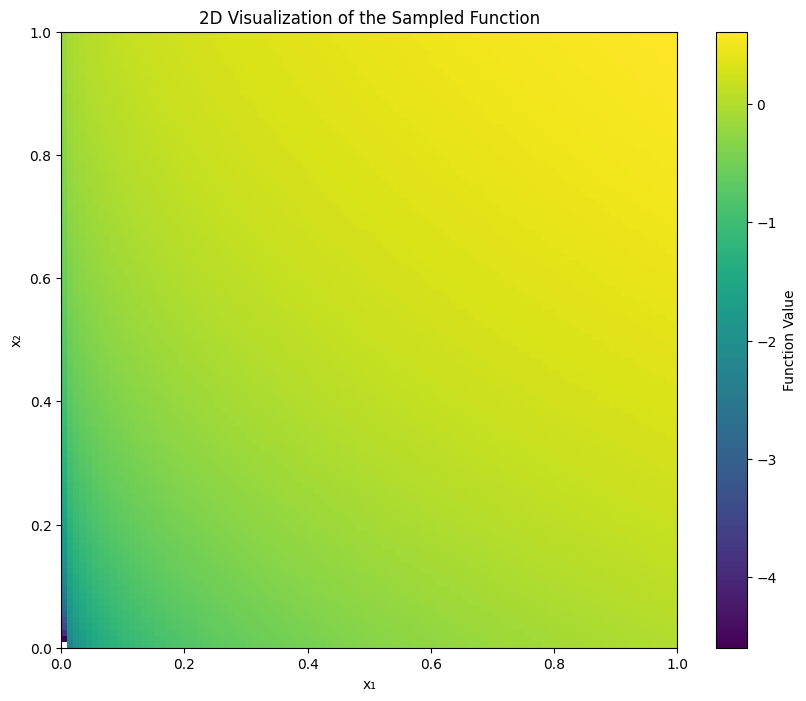

In [47]:
import matplotlib.pyplot as plt
NUM_INPUTS = 2

# Sample a tree
sampled_tree_np = sample_binary_tree_np(target_leaves=NUM_INPUTS, binary_op_sampler=lambda: random.choice(list(binary_ops.keys())), unary_op_sampler=lambda: random.choice(list(unary_ops.keys())))

print("Sampled Tree (NumPy Array):")
print(sampled_tree_np)

# Create a 2D grid for visualization
resolution = 100
x = torch.linspace(0, 1, resolution)
y = torch.linspace(0, 1, resolution)
grid_x, grid_y = torch.meshgrid(x, y, indexing='ij')

# Reshape the grid for evaluation
grid_points = torch.stack([grid_x.flatten(), grid_y.flatten()], dim=1)

# Evaluate the tree on the grid
result = evaluate_tree_np(sampled_tree_np, grid_points)

# Reshape the result for plotting
result_grid = result.reshape(resolution, resolution)

# Plot the function as a 2D image
plt.figure(figsize=(10, 8))
plt.imshow(result_grid, origin='lower', extent=[0, 1, 0, 1], cmap='viridis')
plt.colorbar(label='Function Value')
plt.title('2D Visualization of the Sampled Function')
plt.xlabel('x₁')
plt.ylabel('x₂')
plt.show()


In [33]:
f = sample_operation_tree()

NameError: name 'sample_operation_tree' is not defined

In [16]:
f

('add', ('sub', ('mul', ('inv', ('sub', (1,), (1,))), (0,)), (0,)), (0,))